# Helper Functions
Ignore these for now, we'll go through the code later. Note that everything is in the notebook for easy reproducibility for others - just 1 file needed to run this code

In [1]:

def simulate_conversions(N_per_day, k, lambd, p, days=60, start="2021-01-01 00:00:00", censor=None):
    '''
    N_per_day: The average rate of users per day
    k: The shape parameter of the weibull distribution
    lambd: The scale/rate parameter of the weibull distribution
    p: The Success rate parameter of a bernoulli/binomial distribution
    days: the number of days of data to cohort users
    start: the start datetime of the dataset
    censor: If not none, the dataset is cut off `censor` days after the parameter `days`
    '''
    # Simulate arrivals 
    ## Assumes N_per_day is the rate parameter of a poisson distribution.
    ## A feature of the poisson distribution with parameter lambda is that the time between 
    ## events can be simulated by an exponential distribution with parameter 1/lambda
    arrivals = np.random.exponential(1/N_per_day, size=(N_per_day*60)).cumsum()
    df = pd.DataFrame({
        "start":pd.to_datetime(start), 
        "arrivals":arrivals})
    df["cohort_time"] = df.start + pd.to_timedelta( df.arrivals, unit="d" )
    df.index.name = "user_id" 
    
    # Simulate out time to convert and conversion rate 
    ttc = pm.Weibull.dist(k, lambd).random(size=len(df))
    convert = np.random.binomial(1,p, size=len(df))
    df["convert"] = pd.to_datetime(
        # When users hasnt converted, make convert entry be null
        np.where(convert==1, 
                 df.cohort_time + pd.to_timedelta(ttc, unit="d"),
                 pd.NaT), 
        ).ceil(freq='s') # round nanoseconds to seconds
    
    # if there's no censoring involved, just return the dataframe
    if censor is None:
        return df[["cohort_time", "convert"]]
    
    # if censored, cut-off data
    else:
        end_date = df.cohort_time.max() + timedelta(days=censor)

        df["convert"] = pd.to_datetime(
            np.where(df["convert"] > end_date, pd.NaT, 
                     df["convert"])).ceil(freq='s') 
        
        return df[df.cohort_time <= end_date][["cohort_time", "convert"]]





def cohort_plot(df,ax=None, plot_type="lifetime", freq="W", alpha=1.0, color=None):
    '''
    plot_type supports [date, lifetime]
    '''
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(15,5))

    df = df.copy()
    df.loc[:, "Cohort"] = df.cohort_time\
            .dt.to_period(freq)\
            .apply(lambda x: x.start_time)
    
    # Calculate time from min(current_date, conversion time) to cohort start
    delta = (df.convert.fillna(df.cohort_time.max()) - df.Cohort) 
    df.loc[:, "time_since"] = (delta.dt.days + delta.dt.seconds/60/60/24) # days since cohort start
    df.loc[:, "c"] = df.convert.notnull()*1

    # Calculate cumulative users enrolled in a cohort over time
    users = df.reset_index(drop=True)\
        .groupby("Cohort")\
        .resample("D", on="cohort_time")["c"].count()\
        .groupby("Cohort").cumsum()\
        .rename("N")

    # Calculate cumulative conversions from a cohort over time
    convs = df[df.convert.notnull()]\
        .reset_index(drop=True)\
        .groupby("Cohort")\
        .resample("D", on="convert")["c"].sum()\
        .groupby("Cohort").cumsum()\
        .rename("convs")

    
    tab = pd.concat((convs,users),axis=1)
    tab.loc[:, "convs"] = tab["convs"].groupby("Cohort").ffill().fillna(0)
    tab["N"] = tab["N"].groupby("Cohort").ffill().fillna(0)
    tab["CVR"] = tab["convs"]/tab["N"]
    tab = tab["CVR"].unstack(level=0).ffill()
    tab.columns = tab.columns.astype(str)
    
    ax.set_title("Conversion Rate over time")
    ax.set_ylabel("Conversion Rate")
    
    if plot_type == "date":
        if color:
            tab.plot(ax=ax,alpha=alpha, color=color)
        else:
            tab.plot(ax=ax,alpha=alpha)
    
    # Normalize so that the x-axis is days since cohort start
    elif plot_type == "lifetime":
        arrs = []
        for col in tab.columns:
            arrs.append( pd.Series(tab[tab[col].notnull()][col].values ) )


        tab2 = pd.concat(arrs,axis=1)
        tab2.columns = tab.columns
        if color:
            tab2.plot(ax=ax,alpha=alpha, color=color)
        else:
            tab2.plot(ax=ax,alpha=alpha)
        ax.set_xlabel("Days Since Cohort Start")
        
        
    else:
        raise ValueError("plot_type supports [date, lifetime]")

# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
import seaborn as sns
import scipy.stats as stats
import pymc3 as pm
import arviz as az
from scipy.special import expit
from pymc3.math import dot, sigmoid, log, exp
logistic = lambda x: np.exp(x)/ (1+np.exp(x))

from datetime import datetime, timedelta



# Introduction

---

_Note that this is very heavily influenced from [Erik Bernhardsson's work](https://github.com/better/convoys)_

Conversion rate analysis typically has a common goal of providing business value, and that usually entails understanding the probability that a given customer will convert.

One common flaw in conversion rate data is not accounting for how long it takes to convert. This is particularly important if you're measuring in real time and if theres a delay in the time it takes to convert. 


We'll start by simulating some conversion rate data and plotting it. It's safe to ignore the helper functions for now and focus more on the plots than the code


In [3]:
np.random.seed(99)

N_per_day = int(1_000/7)
full_data = simulate_conversions(N_per_day, k=2.5, lambd=30, p=0.35)

Text(0.5, 1.0, 'Conversion Rate over Time')

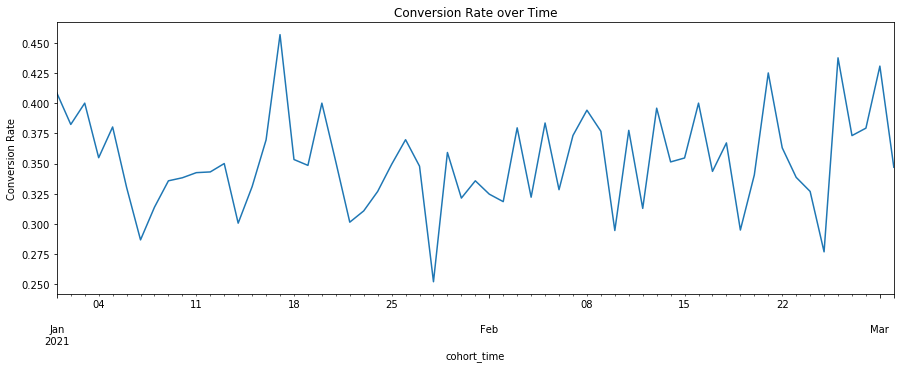

In [4]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
full_data.resample("D", on="cohort_time")["convert"]\
    .apply(lambda x:x.notnull().mean())\
    .plot(ax=ax)

ax.set_ylabel("Conversion Rate")
ax.set_title("Conversion Rate over Time")

One convenient feature of this dataset is that we can see all of the data retrospectively. Notice how the last conversion occurs all the way in May, while the latest cohort date is in march

(Timestamp('2021-03-02 17:23:02.995094399'), Timestamp('2021-05-08 01:40:12'))

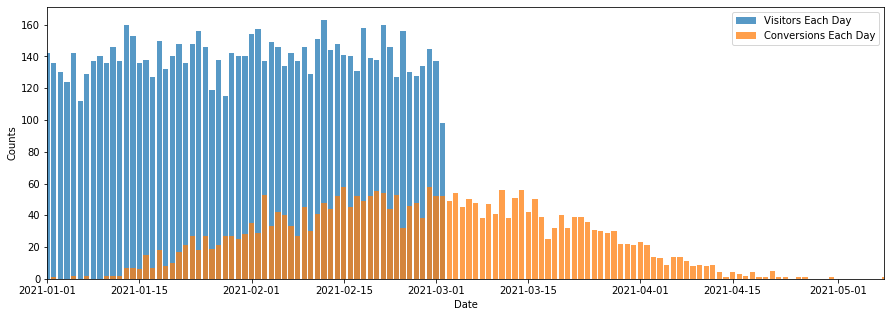

In [5]:
def plot_counts(data, ax):

    ts1= data.resample("D", on="convert").count()["convert"]
    ts2 = data.resample("D", on="cohort_time").count()["cohort_time"]
    ax.bar(ts2.index, ts2,alpha=0.75, color="C0", label="Visitors Each Day")
    ax.bar(ts1.index, ts1,alpha=0.75, color="C1", label="Conversions Each Day")
    ax.set_xlim(datetime(2021,1,1), datetime(2021,5,8))

    plt.ylabel("Counts")
    plt.xlabel("Date")
    plt.legend()
   

fig, ax = plt.subplots(1,1,figsize=(15,5))
plot_counts(full_data,ax=ax)

full_data.cohort_time.max(),full_data.convert.max()

Thats not very realistic in a business setting, as you'd have data available to you right up until the current day. Let's cut off our dataset as if we were performing an analysis on March 2nd 

When we have entries for users that simply may not have been observed yet, it is known as __censoring__. I.e., for these users we haven't observed a conversion yet

In [6]:
df = full_data.copy()
df.loc[(df.convert > df.cohort_time.max()), "convert"] = np.NaN
df.head(10)

,cohort_time,convert
user_id,,
0,2021-01-01 00:11:18.782332800,NaT
1,2021-01-01 00:18:06.191078400,2021-01-24 15:04:40
2,2021-01-01 00:35:48.426028800,NaT
3,2021-01-01 00:36:07.866892800,2021-01-14 08:00:58
4,2021-01-01 00:52:52.127097600,NaT
5,2021-01-01 01:01:19.471267200,NaT
6,2021-01-01 01:04:54.427382400,2021-02-14 10:52:27
7,2021-01-01 01:05:23.524137600,NaT
8,2021-01-01 01:52:44.967417599,NaT


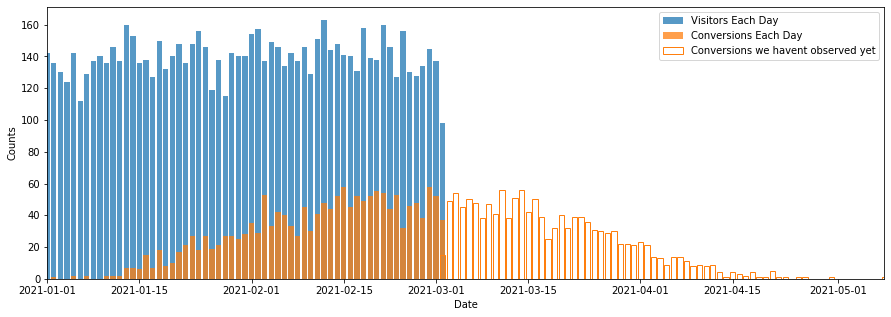

In [7]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
plot_counts(df, ax=ax)
censored_convs = full_data.loc[(full_data.convert > full_data.cohort_time.max())]\
    .resample("D", on="convert").count()["convert"]

ax.bar(censored_convs.index, censored_convs, fill=False, edgecolor='C1', 
       label="Conversions we havent observed yet")
ax.legend();

Let's plot out what our conversion rate looks like now that there's censoring. Something weird is happening - it looks like the conversion rate is tanking. __This is simply because more recent observations haven't had enough time to convert yet__. Sometimes in industry, this is referred to as `cohort baking`

Text(0.5, 1.0, 'Conversion Rate over Time')

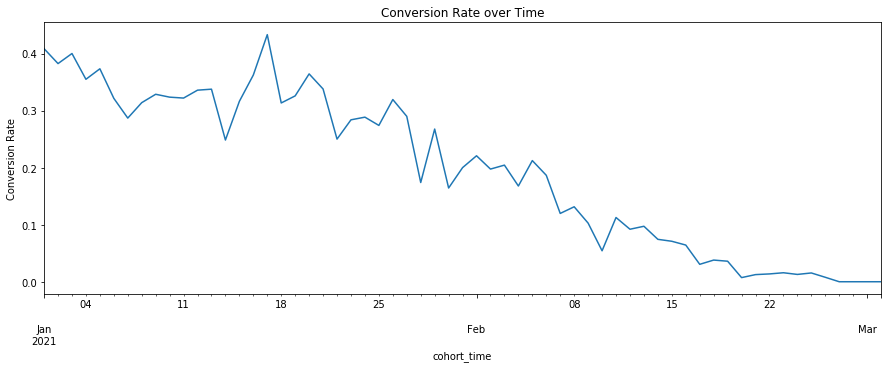

In [8]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
df.resample("D", on="cohort_time")["convert"]\
    .apply(lambda x:x.notnull().mean())\
    .plot(ax=ax)

ax.set_ylabel("Conversion Rate")
ax.set_title("Conversion Rate over Time")

So what's the right way to understand this data? The most common way is to discretize users into cohorts, usually based on the week or the month which they were cohorted.

As a quick sneak peak, we'll plot conversion rate as a function of time since a user was cohorted below

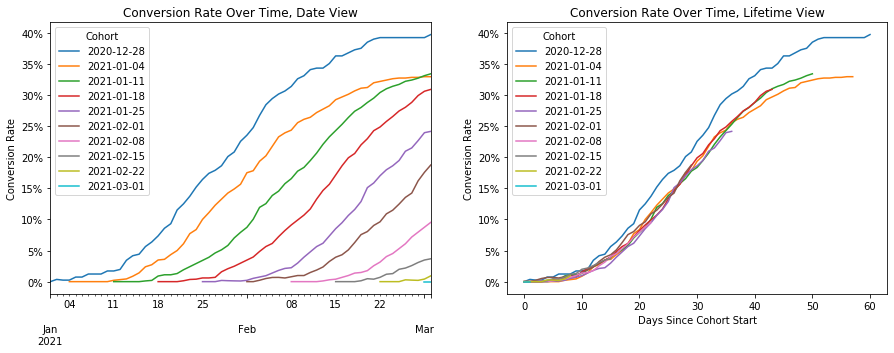

In [9]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

cohort_plot(df, plot_type="date",ax=ax[0])
ax[0].set_title("Conversion Rate Over Time, Date View")
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1,0))

cohort_plot(df, plot_type="lifetime",ax=ax[1])
ax[1].set_title("Conversion Rate Over Time, Lifetime View")
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1,0))



For another great introduction to this problem, [check out this article by Erik Bernhardsson](https://erikbern.com/2017/05/23/conversion-rates-you-are-most-likely-computing-them-wrong.html)

# Simulating Conversion Rate Data
---

Let's simulate conversion data ourselves in order to better understand how this works

### The Binomial Distribution
We'll use the Bernoulli distribution to represent the conversion rate. The binomial distribution has 2 parameters
 * __n__: The number of trials
 * __p__: The success rate

The parameter __p__ is itself commonly modeled with a __beta distribution__, but we wont get into that here

Let's set a conversion rate of $p=0.35$ for 10000 users

In [10]:
n = 10000
p = 0.35
y = np.random.binomial(n=1, p=p ,size=n)
y[:10]

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 1])

By setting n=1, we essentially have a Bernoulli distribution repeated 1000 times, where theres a 35% chance of seeing a 1, which represents success or a conversion.

We can confirm this simply by taking the mean of the array, $y$

In [11]:
y.mean()

0.3496


### The Weibull Distribution
We'll use the Weibull distribution in order to simulate __time to convert__. There are many other commonly used distributions for time to event analysis such as
 * Exponential distribution
 * Generalized Gamma Distribution
 * Gamma Distribution
 * Log-logistic distribution
 

The Weibull distribution has 2 parameters 
 * __k__: shape parameter.
     * When $k < 1$, the event rate decreases over time
     * When $ k = 1$, the event rate is constant over time
     * When $k > 1$, the event rate increases over time
 * $\boldsymbol{\lambda}$: scale parameter, the interpretation is less clear, however its meant to be similar to a rate parameter

Text(0, 0.5, 'CVR')

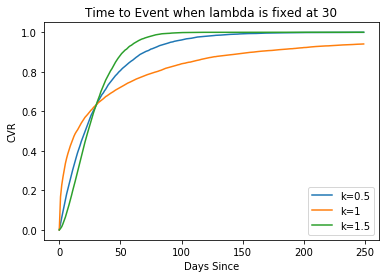

In [12]:
# parameters
lambd = 30
k = 1
t = np.arange(250)

# k=1
events = pm.Weibull.dist(k, lambd).random(size=10000)
plt.plot( (t >= events[:,None]).mean(axis=0), label="k=0.5"  )

# k=0.5
events = pm.Weibull.dist(0.5, lambd).random(size=10000)
plt.plot( (t >= events[:,None]).mean(axis=0), label="k=1"  )

# k=1.5
events = pm.Weibull.dist(1.5, lambd).random(size=10000)
plt.plot( (t >= events[:,None]).mean(axis=0), label="k=1.5" )

plt.legend()
plt.title("Time to Event when lambda is fixed at 30")
plt.xlabel("Days Since")
plt.ylabel("CVR")

Text(0, 0.5, 'CVR')

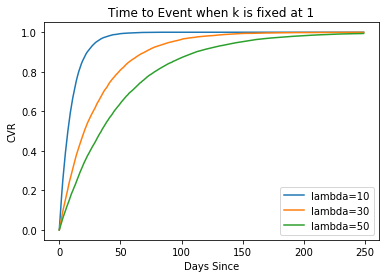

In [13]:
k = 1
t = np.arange(250)

# lambda=10
eventsA = pm.Weibull.dist(k, 10).random(size=10000)
plt.plot( (t >= eventsA[:,None]).mean(axis=0), label="lambda=10"  )

# lambda=30
eventsB = pm.Weibull.dist(k, 30).random(size=10000)
plt.plot( (t >= eventsB[:,None]).mean(axis=0), label="lambda=30"  )

# lambda=50
eventsC = pm.Weibull.dist(k, 50).random(size=10000)
plt.plot( (t >= eventsC[:,None]).mean(axis=0), label="lambda=50" )

plt.legend()
plt.title("Time to Event when k is fixed at 1")
plt.xlabel("Days Since")
plt.ylabel("CVR")

Notice that when k=1, the mean event time is equal to lambda. This isnt the case when k differs from 1 however

In [14]:
eventsA.mean(), eventsB.mean(), eventsC.mean()

(10.019883745676596, 30.140274041282687, 48.97183992780737)

Another key point here - __notice how conversion rate when using the Weibull distribution always converges to 1.__ This is equivalent to assuming that all users eventually convert, which simply is not true. This is why we bring in the binomial distribution to represent conversion rate

## Combining the distributions

We'll start by defining some parameters

In [15]:
# start by defining some parameters
p = 0.5
k = 2.5
lambd = 10

n_users = 10
t = np.arange(20+1)

We'll have an array simulated from a binomial distribution to represent who converted


In [16]:
np.random.seed(99)
convert = np.random.binomial(1,p,size=n_users)
convert

array([1, 0, 1, 0, 1, 1, 0, 0, 1, 0])

We'll have an array simulated from a weibull distribution to represent when people convert (the Weibull distribution assumes everyone converts, so we need to multiply it by the binomial distribution later to relax that assumption)

In [17]:
np.random.seed(99)
time_to_event = pm.Weibull.dist(k, lambd).random(size=n_users)
time_to_event

array([ 6.91118153,  8.7553861 ,  5.16551889, 16.42872598,  5.38838929,
        7.98546793, 10.79918361, 15.65025183,  1.547253  , 19.01681063])

We're going to do some fancy matrix operations here to make things quick.

 * In the matrix below of shape (m,n), each row is a different user (from user 0 to n), while each column is a different time (from time 0 to n)
 * A users entry at time t is 0 if they have not converted yet, and it is 1 if they have converted

In [18]:
arr = (t >= time_to_event[:,None])*1 
arr

array([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

notice that we can calculate the conversion rate at time $t$ simply by taking the mean of each column

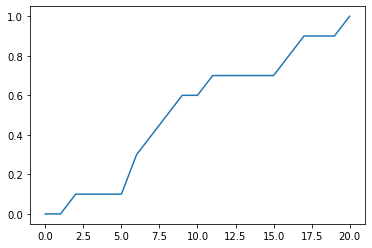

In [19]:
plt.plot( arr.mean(axis=0) )

Now we'll take that array and multiply it by 1 if a user converted and 0 if they did not convert

In [20]:
Ft = arr * convert[:,None]
Ft

array([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Notice how the conversion rate no longer converges to 1 - instead it converges to the success rate of the binomial distribution

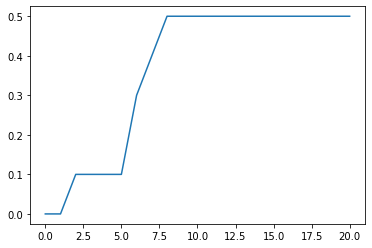

In [21]:
plt.plot( Ft.mean(axis=0) )

Alright, now all we're missing is 1 last piece, the censoring. All we have to do is cut off our data. Lets pretend we only see up until time $t=10$. To do that, anyone who converts later than T>t, we'll set $\text{convert}=0$ and $T=t$

For this one, we're going to re-simulate with more users to make our cohort curves more stable

In [22]:
n_users = 1000
t = np.arange(20+1)

# params
p = 0.5
k = 2.5
lambd = 10

# Simulate
np.random.seed(99)
time_to_event = pm.Weibull.dist(k, lambd).random(size=n_users)
convert = np.random.binomial(1,p,size=n_users)

# Non censored data
df = pd.DataFrame({"B":convert, "T":time_to_event})
df.index.name = "user_id"

# Censored data
df_c = pd.DataFrame({"B":convert, "T":time_to_event})
df_c.index.name = "user_id"

df_c["B"] = np.where(df_c["T"]  > 10, 0, df_c["B"])
df_c["T"] = np.where(df_c["T"]  > 10, 10, df_c["T"] )
df_c.sample(10)

,B,T
user_id,,
931,0,7.839085
838,1,7.595722
547,0,1.816717
424,0,7.640983
448,0,10.000000
109,0,5.403055
52,0,10.000000
903,0,10.000000
856,1,3.372758


Text(0.5, 1.0, 'Cohorted Conversion')

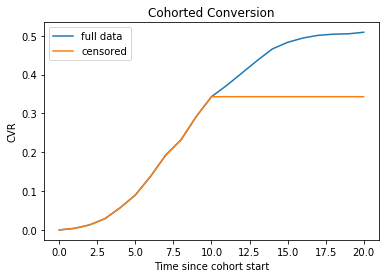

In [23]:
Ft = (t >= df["T"].values[:,None])* df.B.values[:,None]
plt.plot(Ft.mean(axis=0), label="full data")

Ft_c = (t >= df_c["T"].values[:,None])* df_c.B.values[:,None]
plt.plot(Ft_c.mean(axis=0), label="censored")

plt.legend()
plt.ylabel("CVR")
plt.xlabel("Time since cohort start")
plt.title("Cohorted Conversion")

## Full simulation 
The full function (a bit scrappy right now) to simulate data is shown below. Users become cohorted, simulated by a poisson distirbution, and then a weibull and binomial distribution are used to decide if and when users convert

In [24]:
def simulate_conversions(N_per_day, k, lambd, p, days=60, start="2021-01-01 00:00:00", censor=None):
    '''
    N_per_day: The average rate of users per day
    k: The shape parameter of the weibull distribution
    lambd: The scale/rate parameter of the weibull distribution
    p: The Success rate parameter of a bernoulli/binomial distribution
    days: the number of days of data to cohort users
    start: the start datetime of the dataset
    censor: If not none, the dataset is cut off `censor` days after the parameter `days`
    '''
    # Simulate arrivals 
    ## Assumes N_per_day is the rate parameter of a poisson distribution.
    ## A feature of the poisson distribution with parameter lambda is that the time between 
    ## events can be simulated by an exponential distribution with parameter 1/lambda
    arrivals = np.random.exponential(1/N_per_day, size=(N_per_day*days)).cumsum()
    df = pd.DataFrame({
        "start":pd.to_datetime(start), 
        "arrivals":arrivals})
    df["cohort_time"] = df.start + pd.to_timedelta( df.arrivals, unit="d" )
    df.index.name = "user_id" 
    
    # Simulate out time to convert and conversion rate 
    ttc = pm.Weibull.dist(k, lambd).random(size=len(df))
    convert = np.random.binomial(1,p, size=len(df))
    df["convert"] = pd.to_datetime(
        # When users hasnt converted, make convert entry be null
        np.where(convert==1, 
                 df.cohort_time + pd.to_timedelta(ttc, unit="d"),
                 pd.NaT), 
        ).ceil(freq='s') # round nanoseconds to seconds
    
    # if there's no censoring involved, just return the dataframe
    if censor is None:
        return df[["cohort_time", "convert"]]
    
    # if censored, cut-off data
    else:
        end_date = df.cohort_time.max() + timedelta(days=censor)

        df["convert"] = pd.to_datetime(
            np.where(df["convert"] > end_date, pd.NaT, 
                     df["convert"])).ceil(freq='s') 
        
        return df[df.cohort_time <= end_date][["cohort_time", "convert"]]



In [25]:
cohort = simulate_conversions(100, 2.5, 70, 0.25, days=120, censor=0)
cohort.head(15)

,cohort_time,convert
user_id,,
0,2021-01-01 00:19:42.143635200,NaT
1,2021-01-01 00:40:32.576448000,NaT
2,2021-01-01 00:51:22.148668800,NaT
3,2021-01-01 01:01:08.350723200,NaT
4,2021-01-01 01:28:11.477280000,NaT
5,2021-01-01 01:51:03.544531200,NaT
6,2021-01-01 02:04:48.973670400,NaT
7,2021-01-01 02:13:56.002224000,NaT
8,2021-01-01 02:28:42.558585600,NaT


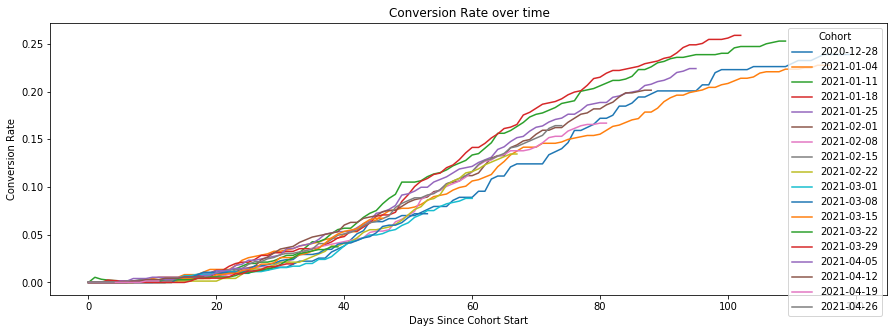

In [26]:
cohort_plot(cohort)

# Modeling Conversion Rate data

---

Modeling conversion rate data is tricky since, the format of the data is simply two datetime columns of cohort start and conversion time.

[Convoys](https://github.com/better/convoys) is a great package to do this out of the box. However there might be times when you need a more custom approach, and knowing how to model it yourself is very useful

Let's start by transforming the data so its ready for modeling. To do this, we'll create 2 vectors, $B$ and $T$, using the same convention as _Convoys_.

In [27]:
cohort = simulate_conversions(N_per_day, 2.5, 40, 0.25, days=120, censor=0)
cohort.head()

,cohort_time,convert
user_id,,
0,2021-01-01 00:06:27.042278400,NaT
1,2021-01-01 00:09:36.796377600,2021-01-14 12:10:50
2,2021-01-01 00:10:42.252844800,NaT
3,2021-01-01 00:42:30.897532800,2021-01-28 21:32:47
4,2021-01-01 00:50:00.064348800,NaT


In [28]:
B = (cohort.convert.notnull()*1).values
analysis_date = cohort.cohort_time.max() + pd.Timedelta(days=1) # 1 day after last cohorted observation
delta = cohort.convert.fillna(analysis_date) - cohort.cohort_time
T = (delta.dt.days + delta.dt.seconds/60/60/24).values

print(B)
print("\n")
print(T)

[0 1 0 ... 0 0 0]


[121.50302083  13.50084491 121.50006944 ...   1.00803241   1.00052083
   1.        ]


Great we now have the format we need. Now let's break out the model. We'll use PyMC3, a bayesian modeling framework. This code snippet below is directly adapted from code from an early github commit on the [Convoys](https://github.com/better/convoys) package

It's a tricky model for a few reasons:
 1. We need a custom likelihood function. 
 2. Our observed data is from a joint conversion rate and time to event model
 3. We have censored observations (we're not sure if a user will never convert, or if they just haven't converted yet)
 4. Overflow issues. We calculate everthing on the log-probability scale to prevent these (i.e. numbers too big or numbers too small for a computer to handle properly)
 
Luckily PyMC3 has a `pm.Potential()` function that can allow us to have custom likelihood functions

The likelihood function for this model works as follows

__Step 1: Log Probability of the data given the model__
$$
\text{logp} = B * \text{LL_observed} + (1 - B) * \text{LL_censored}
$$

Remember that B is simply a vector of 1s (converts) and 0s (non-converts). What this line is telling us is that if a user converts (B=1), then the log-likelihood to factor in is `LL_observed`. Otherwise when B=0, and therefore $(1-B)=1$, the log likelihood to factor in and fit on is `LL_censored`

__Step 2: Log-likelood for observed conversions__

The log-likelihood for observed conversions is simple - its just the PDF (probability density function) of the weibull distribtion, multiplied by the probability of conversion. With some algebra, we do this on the log scale and get the following:
$$
\text{LL_observed} = log(c) + log(k) - log(\lambda) + (k-1)(log(T) - log(\lambda)) - (T/\lambda)^k
$$

__Step 3: Log-likelood for censored observations conversions__

The log likelihood for censored observations is a little more complicated. If a user hasn't converted yet, there are two possibilities
 * They could not convert with probability $1-c$
 * The could convert based on the time to event function and the conversion rate $c$

In the former scenario where a user doesnt convert, this is simple, the probability is $(1-C)$. The latter scenario is difficult to understand. The probability of a user not having converted at time $T$ is the survival function, which is the inverse of the CDF (1-CDF), multiplied by the probability of that user converting, $c$. 

$$
\text{LL_censored} = log( (1-c) + c e^{-(T/\lambda)^k} )
$$


In [29]:

def censored_cvr_logp(c, k, lambd, T):
    # PDF of Weibull: k / lambda * (x / lambda)^(k-1) * exp(-(t / lambda)^k)
    LL_observed = log(c) + log(k) - log(lambd) + (k-1)*(log(T) - log(lambd)) - (T/lambd)**k
    
    # CDF of Weibull: 1 - exp(-(t / lambda)^k)
    # (1-C) + C * SF (survival fxn) = C * 1-CDF 
    LL_censored = log((1-c) + c * exp(-(T/lambd)**k))
    
    # We need to implement the likelihood using pm.Potential 
    logp = B * LL_observed + (1 - B) * LL_censored
    return logp
    


with pm.Model() as m:
    
    c = pm.Beta('c', alpha=25, beta=75)  # conversion rate prior
    k = pm.Lognormal('k', mu=0.5, sd=1.0)  # Weak prior for k
    lambd = pm.Exponential('lambd', 0.01)  # Weak prior
    logprob = pm.Potential('logprob', censored_cvr_logp(c, k, lambd, T).sum())



In [30]:
with m:
    trace = pm.sample(init="advi+adapt_diag", return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 11300
Interrupted at 11,299 [5%]: Average Loss = 1.5557e+06
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambd, k, c]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


Great the model fit quickly and without any divergences which is a good sign. We'll look at the trace plots below.

On the left column, we see posterior distribution plots, while in the right column we see trace plots - white noise is a good sign that the posterior distribution was explored efficiently, which is exactly what we see

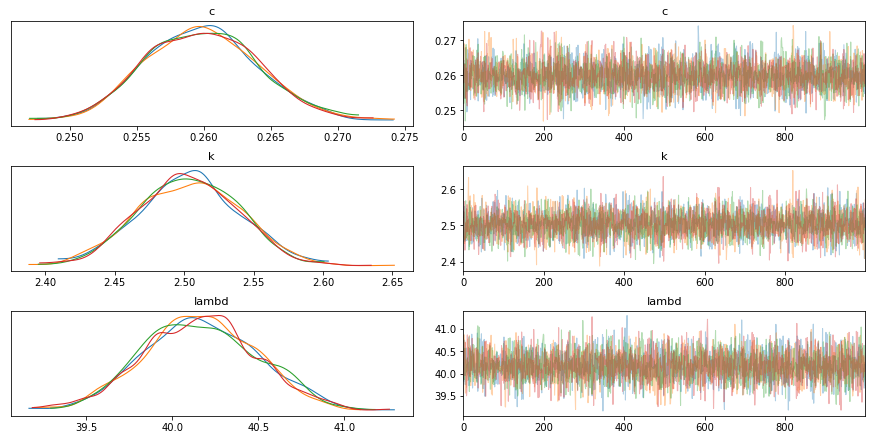

In [31]:
pm.plot_trace(trace);

__Even better, our pre-specified parameters from the `simulate_conversions()` function were properly recovered by the model)__

We can use our posterior distributions to model out the conversion rate at each time T, with uncertainty

In [32]:
cvr_ = trace.posterior["c"].values.reshape(4000,)
lambd_ = (trace.posterior["lambd"]).values.reshape(4000,)
k_ = (trace.posterior["k"]).values.reshape(4000,)

/usr/local/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


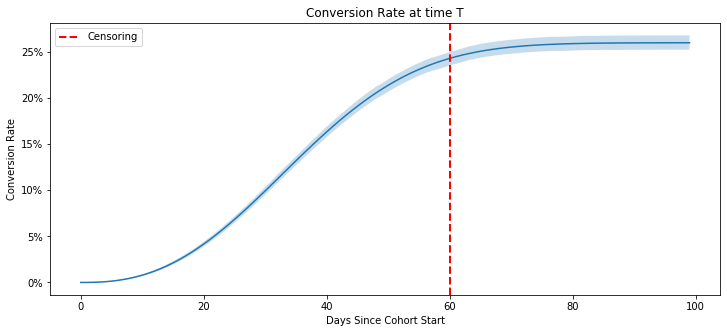

In [33]:
t_ = np.arange(0, 100,1)
Ft = ((1-np.exp(-(t_ / lambd_[:, None])**k_[:, None])) * (cvr_[:,None])).T
ci = az.hdi(Ft.T)

fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(t_, Ft.mean(axis=1));
ax.fill_between(t_, ci[:,0], ci[:,1], alpha=0.25)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,0))
ax.set_ylabel("Conversion Rate")
ax.set_xlabel("Days Since Cohort Start")
ax.set_title("Conversion Rate at time T")
ax.axvline(60, color="r", ls="--", lw=2, label="Censoring")
ax.legend()

The great news is, if we feel comfortable that our assumption of a Weibull distribution was correct, we can extrapolate out what the conversion rate will be later in time. 

We'll overlay the model with the actual data below

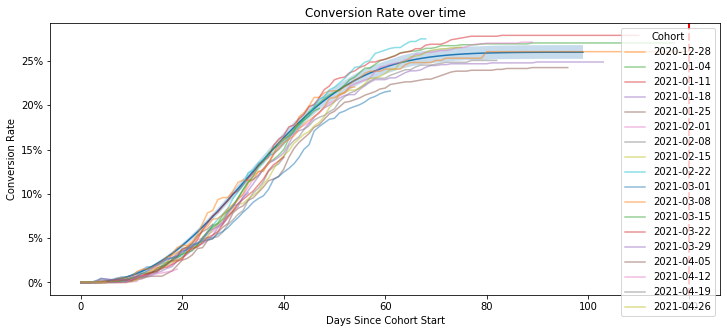

In [34]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(t_, Ft.mean(axis=1));
ax.fill_between(t_, ci[:,0], ci[:,1], alpha=0.25)
ax.axvline(120, color="r", ls="--", lw=2, label="Censoring")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,0))
cohort_plot(cohort,ax=ax, alpha=0.5)


# Extending this to regression modeling

--- 

With PyMC3, we can easily regress data onto our rate and conversion parameters. We'll simulate out some data below that is censored at day 100

Text(0.5, 0, 'Time')

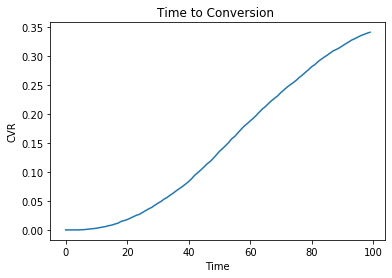

In [35]:
N = 10_000
days = 100
t = np.arange(0, days,1)

# simulate out some covariate X for each user
X = np.random.normal(size=N)[:,None]

# parameters
gamm = 0.1
aT = np.log(70) # 4.24 
b = -0.2
aC = -0.5

# simulate data
lambd_true = np.exp( aT + gamm*X )
T_true = pm.Weibull.dist(2.5, lambd_true).random(size=N) # true time to event (independent of conversion itself)
CVR = logistic( b*X + aC )
# only call it a conversion if they wouldve converted by now AND they convert
p = np.random.binomial(1, CVR)
B = ((T_true < t.max()) & (p.ravel() == 1))*1

# adjust T for non-converts
ttc = (t >= np.where(B==1, T_true, 10000)[:,None]*1)
T = np.where((p.ravel()==0) | (T_true > t.max()), t.max(), T_true)

plt.plot(ttc.mean(axis=0))
plt.title("Time to Conversion ")
plt.ylabel("CVR")
plt.xlabel("Time")


We'll now fit a slightly more complicated model, that regresses lambda and CVR onto X.

`InverseGamma(1,1)` was chosen as a hierarchical regularizing prior on both the $\beta$ and $\gamma$ coefficients, as suggested in the `Convoys` documentation

In [36]:
n, ncoefs = X.shape

with pm.Model() as m2:
    alpha_c = pm.Normal('alpha_c', -5, 1) # intercept for conversion rate
    alpha_lambd = pm.Normal('alpha_lambd', -5, 1) # intercept for conversion rate

    beta_sd = pm.InverseGamma('beta_sd', 1.0,1.0)  # regularizing prior for the regression coefficients
    beta = pm.Normal('beta', mu=0, sd=beta_sd, shape=(ncoefs,))  # Regression coefficients
    gamm = pm.Normal('gamm', mu=0, sd=beta_sd, shape=(ncoefs,))  # Regression coefficients

    c = sigmoid(dot(X, beta) + alpha_c)  # Conversion rates for each example
    lambd = pm.math.exp(dot(X, gamm) + alpha_lambd)
 
    k = pm.Lognormal('k', mu=0.5, sd=1.0)  # Weak prior around k=1

    logprob = pm.Potential('logprob', censored_cvr_logp(c, k, lambd, T).sum())



In [37]:
with m2:
    trace = pm.sample(init="advi+adapt_diag", return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 40600
Interrupted at 40,599 [20%]: Average Loss = 9.3249e+90
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, gamm, beta, beta_sd, alpha_lambd, alpha_c]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


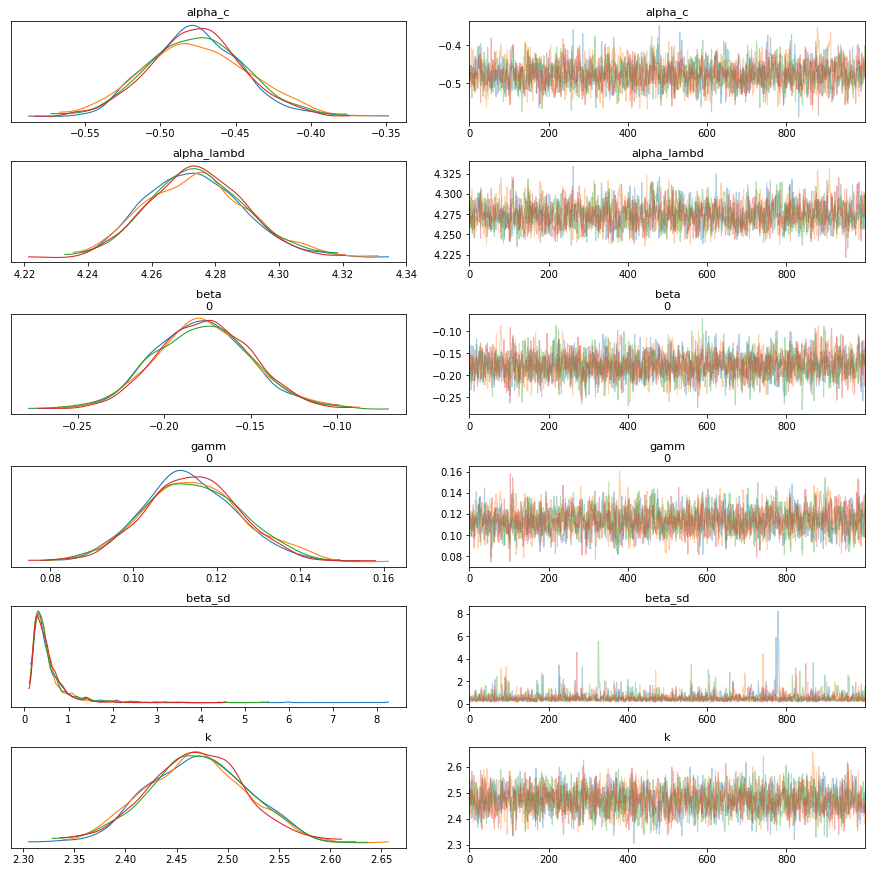

In [38]:
pm.plot_trace(trace);

# Real World Scenario

---

Let's say you run an A/B Test, and you want to identify which variant is better. We'll Ignore prior selection right now to keep things brief.

In [39]:
N_per_day = 500
np.random.seed(90)

groupA = simulate_conversions(N_per_day, 2.5, 7, 0.3, days=14, censor=0)\
    .assign(group = "A")

groupB = simulate_conversions(N_per_day, 1.5, 4, 0.25, days=14, censor=0)\
    .assign(group = "B")


df = pd.concat((groupA, groupB))
df

,cohort_time,convert,group
user_id,,,
0,2021-01-01 00:00:28.705276800,2021-01-08 15:39:19,A
1,2021-01-01 00:00:58.358102400,2021-01-09 01:50:27,A
2,2021-01-01 00:13:09.819465600,NaT,A
3,2021-01-01 00:19:55.658496000,2021-01-08 04:00:33,A
4,2021-01-01 00:20:31.236460800,NaT,A
...,...,...,...
6995,2021-01-14 18:44:14.664710400,NaT,B
6996,2021-01-14 18:46:24.423168000,NaT,B
6997,2021-01-14 18:48:48.000787199,NaT,B


Notice from the simulation that group B, the variant, converts faster but has a worse conversion rate. Let's analyze this like we might for any other experiment

In [40]:
convs = df.groupby("group").apply(lambda x: x.convert.notnull().sum())
N = df.groupby("group").count()["cohort_time"]


Text(0.5, 0, 'CVR')

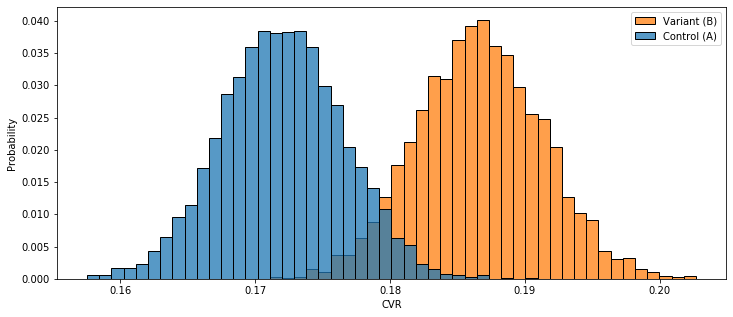

In [41]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
sns.histplot( np.random.beta(convs, N-convs, size=(4000,2)) , ax=ax, bins=50,stat="probability")
ax.legend(["Control (A)", "Variant (B)"][::-1])
ax.set_xlabel("CVR")


If we were simply to go off of using a beta distribution, we'd find the variant is better than the control. 

However, lets take the cohorted view

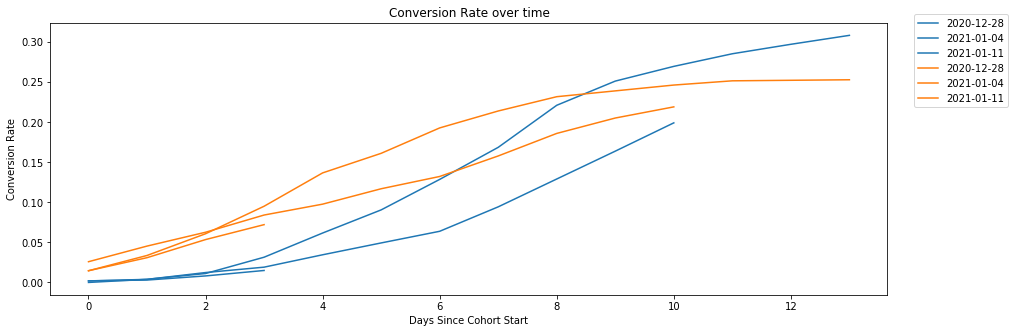

In [42]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
cohort_plot(df[df.group=="A"], color="C0",ax=ax, freq="W")
cohort_plot(df[df.group=="B"], color="C1",ax=ax, freq="W")
ax.legend(bbox_to_anchor=(1.15, 1.05), loc='upper right', ncol=1)


As shown above, the control cohort seems to bake out better. Let's check with our model

In [43]:
B = (df.convert.notnull()*1).values
analysis_date = df.cohort_time.max() + pd.Timedelta(days=1) # 1 day after last cohorted observation
delta = df.convert.fillna(analysis_date) - df.cohort_time
T = (delta.dt.days + delta.dt.seconds/60/60/24).values

v_, labels = pd.factorize(df.group) # variant

with pm.Model() as m_AB:
    
    c = pm.Beta('c', alpha=30, beta=70, shape=2)  # conversion rate prior
    k = pm.Lognormal('k', mu=0.5, sd=1.0, shape=2)  # Weak prior for k
    lambd = pm.Exponential('lambd', 0.01, shape=2)  # Weak prior
    logprob = pm.Potential('logprob', censored_cvr_logp(c[v_], k[v_], lambd[v_], T).sum())


In [44]:
with m_AB:
    trace_AB = pm.sample(init="advi+adapt_diag", return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 21100
Interrupted at 21,099 [10%]: Average Loss = 12,325
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambd, k, c]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


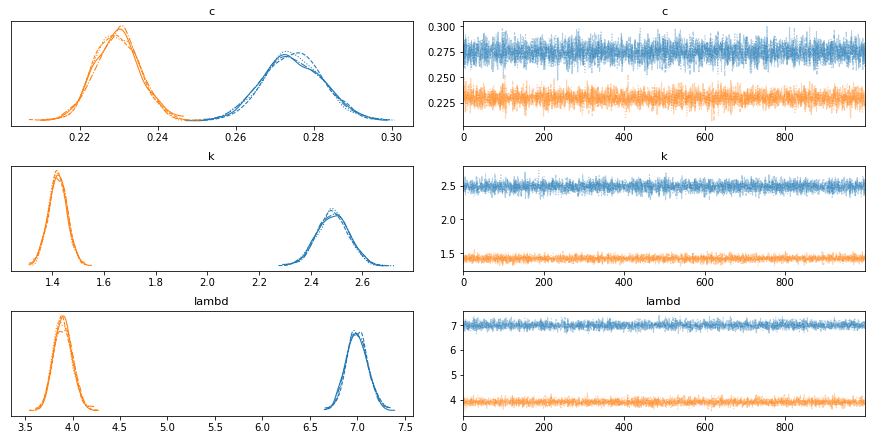

In [45]:
pm.traceplot(trace_AB);

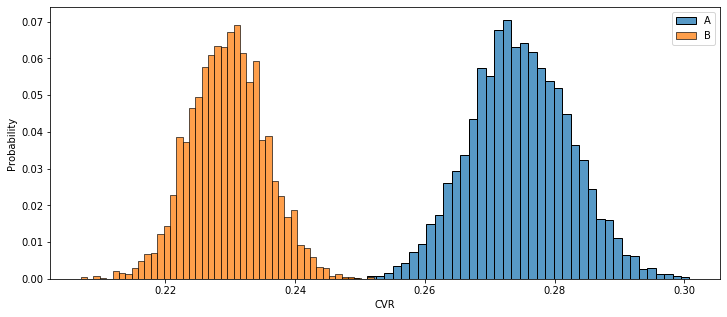

In [46]:
cvr = trace_AB.posterior["c"].values.reshape(4000,2)
lam = trace_AB.posterior["lambd"].values.reshape(4000,2)
k = trace_AB.posterior["k"].values.reshape(4000,2)

fig, ax = plt.subplots(1,1,figsize=(12,5))
sns.histplot( cvr[:,0], label=labels[0], stat="probability" )
sns.histplot( cvr[:,1], label=labels[1], color="C1" , stat="probability")
ax.set_xlabel("CVR")
ax.legend()

/usr/local/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


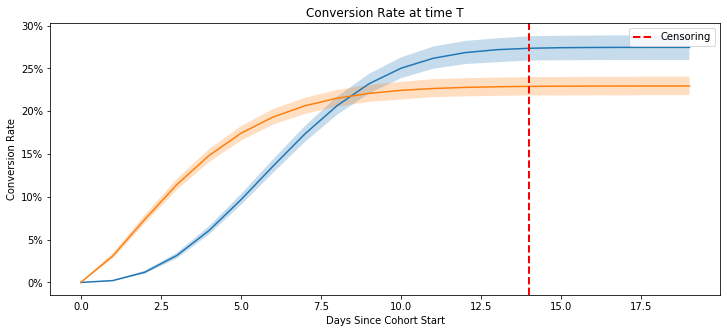

In [47]:
t_ = np.tile(np.arange(0, 20,1),2).reshape(2,20).T
Ft = ((1-np.exp(-(t_ / lam[:, None])**k[:, None])) * (cvr[:,None])).T
ci0 = az.hdi(Ft[0,:,:].T)
ci1 = az.hdi(Ft[1,:,:].T)

fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(t_[:,0], Ft[0,:,:].mean(axis=1));
ax.plot(t_[:,1], Ft[1,:,:].mean(axis=1));

ax.fill_between(t_[:,0], ci0[:,0], ci0[:,1], alpha=0.25)
ax.fill_between(t_[:,1], ci1[:,0], ci1[:,1], alpha=0.25)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,0))
ax.set_ylabel("Conversion Rate")
ax.set_xlabel("Days Since Cohort Start")
ax.set_title("Conversion Rate at time T")
ax.axvline(14, color="r", ls="--", lw=2, label="Censoring")
ax.legend()

While these are still biased a little low since we havent observed the full dataset yet, we correctly identify that group A converts better despite the slower journey.

# Working with Net Present Values

---

In many cases, there might be a very slow conversion process, where the time to convert may make a difference when you take into account the present value of future cash flows, or the __Net Present Value__. You can read more on this [here](https://www.investopedia.com/terms/n/npv.asp)

Adjusting for net present value is relatively easy once you know your __discount rate__. Let's pretend we work at a company with a slow converting process and a __discount rate of 5% per month__ _(note, this is a large discount rate simply for examples sake)_. What variant of our fake experiment below is better?

To start, we'll assume that we found that the expected revenue per user stays constant between the two groups and we'll represent that with the posterior distribution `E_revenue` below

Text(0.5, 0, 'Revenue')

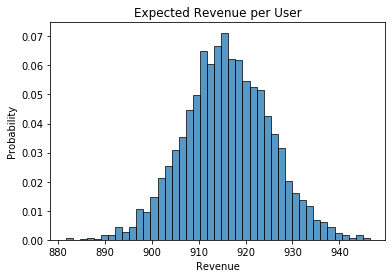

In [48]:
theta = np.random.normal(6.5, 0.01, size=4000)
sigma = np.random.normal(0.8, 0.001, size=4000)

E_revenue = np.exp(theta + 0.5*sigma**2)
sns.histplot( E_revenue, stat="probability" )
plt.title("Expected Revenue per User")
plt.xlabel("Revenue")

Next we'll simulate out some experiment data and fit a model to it

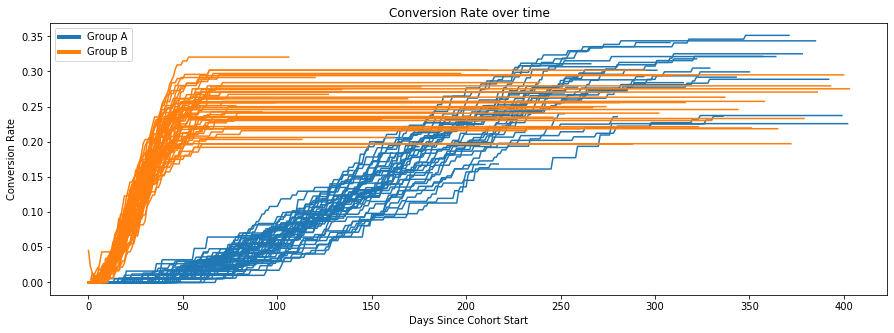

In [49]:
np.random.seed(90)

N_per_day = 25 # keeping this small so the model fits quickly

groupA = simulate_conversions(N_per_day, 2.5, 180, 0.3, days=400, censor=0)\
    .assign(group = "A")
groupB = simulate_conversions(N_per_day, 2.0, 30, 0.25, days=400, censor=0)\
    .assign(group = "B")

df = pd.concat((groupA, groupB))

# Plot out the two groups
fig, ax = plt.subplots(1,1,figsize=(15,5))
cohort_plot(df[df.group=="A"], color="C0",ax=ax, freq="W")
cohort_plot(df[df.group=="B"], color="C1",ax=ax, freq="W")
ax.get_legend().remove()

# helper for legends
legend_lines = [Line2D([0], [0], color="C0", lw=4),
                Line2D([0], [0], color="C1", lw=4)]

ax.legend(legend_lines, ['Group A', 'Group B'])



In [50]:
# Get the data into usable form for modeling
v_, labels = pd.factorize(df.group) # variant
B = (df.convert.notnull()*1).values
analysis_date = df.cohort_time.max() + pd.Timedelta(days=1) # 1 day after last cohorted observation

delta = df.convert.fillna(analysis_date) - df.cohort_time 
T = (delta.dt.days + delta.dt.seconds/60/60/24).values # Time in days as a float


with pm.Model() as m_AB:
    
    c = pm.Beta('c', alpha=30, beta=70, shape=2)  # conversion rate prior
    k = pm.Lognormal('k', mu=0.5, sd=1.0, shape=2)  # Weak prior for k
    lambd = pm.Exponential('lambd', 0.01, shape=2)  # Weak prior
    logprob = pm.Potential('logprob', censored_cvr_logp(c[v_], k[v_], lambd[v_], T).sum())



In [51]:
with m_AB:
    trace_AB = pm.sample(init="advi+adapt_diag", return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 11900
Interrupted at 11,899 [5%]: Average Loss = 3.2168e+10
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambd, k, c]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


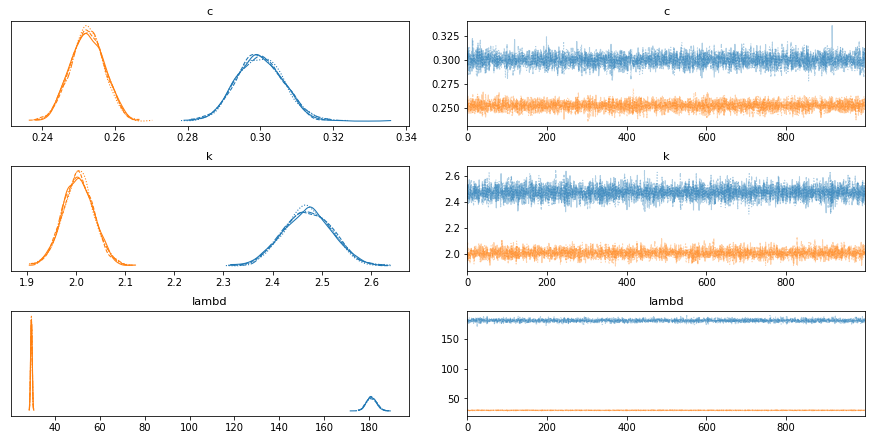

In [52]:
pm.traceplot(trace_AB);

Great we gave a fitted model with no divergences - let's plot out the cohort curves to see what conversion rate over time looks like for a cohort of users in each group

In [53]:

def plot_curve(Ft, t_,ax, pct=True):
    '''helper function for plotting'''
    ci0 = az.hdi(Ft[0,:,:].T)
    ci1 = az.hdi(Ft[1,:,:].T)


    ax.plot(t_[:,0], Ft[0,:,:].mean(axis=1));
    ax.plot(t_[:,1], Ft[1,:,:].mean(axis=1));

    ax.fill_between(t_[:,0], ci0[:,0], ci0[:,1], alpha=0.25)
    ax.fill_between(t_[:,1], ci1[:,0], ci1[:,1], alpha=0.25)
    if pct:
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,2))
    ax.set_ylabel("Conversion Rate")
    ax.set_xlabel("Days Since Cohort Start")
    ax.set_title("Conversion Rate at time T")
    ax.legend()

/usr/local/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
No handles with labels found to put in legend.


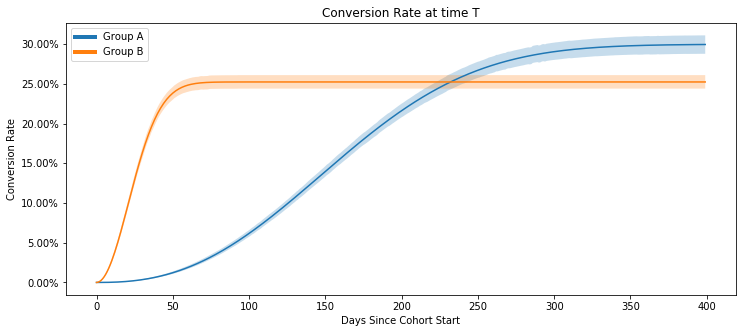

In [54]:
cvr = trace_AB.posterior["c"].values.reshape(4000,2)
lam = trace_AB.posterior["lambd"].values.reshape(4000,2)
k = trace_AB.posterior["k"].values.reshape(4000,2)

t_ = np.tile(np.arange(0, 400, 1),2).reshape(2,400).T
Ft = ((1-np.exp(-(t_ / lam[:, None])**k[:, None])) * (cvr[:,None])).T
    

fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_curve(Ft, t_, ax=ax, pct=True)
ax.legend(legend_lines, ['Group A', 'Group B'])


Looking at this, group A, the control, has a higher final conversion rate. But this doesnt take into account the time value of money. 

Let's factor in revenue - to do so we'll want to take the net present value of revenue at each time T, as shown below

Text(0, 0.5, 'NPV of Revenue')

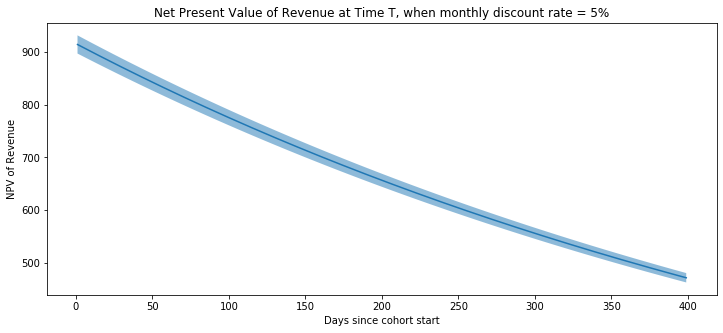

In [55]:
discount_rate = .05 # monthly
adj = (1 + discount_rate/30) ** (t_ [1:])
npv_Revenue = (np.c_[E_revenue,E_revenue][:,None] / adj)

ci = az.hdi(npv_Revenue[:,:,0])

fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(t_[1:,0], npv_Revenue[:,:,0].mean(axis=0) )
ax.fill_between(t_[1:,0], ci[:,0], ci[:,1], alpha=0.5)
ax.set_title("Net Present Value of Revenue at Time T, when monthly discount rate = 5%")
ax.set_xlabel("Days since cohort start")
ax.set_ylabel("NPV of Revenue")

As we can see above, the net present value of revenue decreases over time by quite a bit. \$900 at 400 days out is worth about \\$500 in net present value.

Let's now factor this into our conversion rate - to make things more interpretable, we want to put things in terms of incremental revenue

No handles with labels found to put in legend.


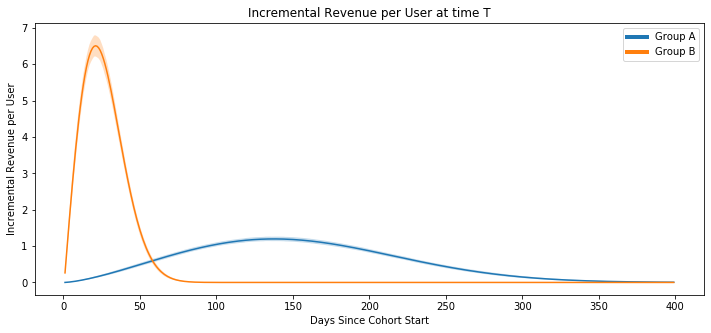

In [56]:
# incremental revenue
cFt = Ft[:,1:,:] - Ft[:,:-1,:]

fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_curve( (cFt*npv_Revenue.T), t_[1:], ax=ax, pct=False)
ax.set_title("Incremental Revenue per User at time T")
ax.set_ylabel("Incremental Revenue per User")
ax.legend(legend_lines, ['Group A', 'Group B'])


We can also calculate a distribution for net present value, and find the probability that group B is greater than A

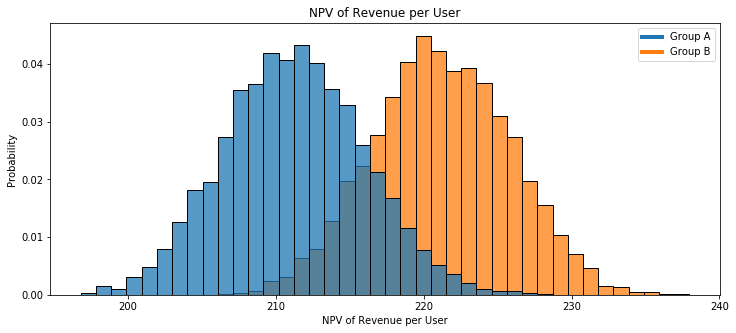

In [57]:
# sum up all of our incremental revenues to get a distribution 
# for NPV
npv = (cFt*npv_Revenue.T).sum(axis=1).T

fig, ax = plt.subplots(1,1,figsize=(12,5))
sns.histplot( npv,ax=ax , stat="probability")
ax.set_xlabel("NPV of Revenue per User")
ax.set_title("NPV of Revenue per User")
ax.legend(legend_lines, ['Group A', 'Group B'])


In [58]:
A = npv[:,0]
B = npv[:,1]

"P(B > A) = {:.2%}".format( (B > A ).mean() )

'P(B > A) = 95.45%'

Despite group A having a greater overall conversion rate, we identified that group B has a higher net present value since those users are converting faster!

## References

 * https://github.com/better/convoys
 * https://erikbern.com/2019/08/05/modeling-conversion-rates-using-weibull-and-gamma-distributions.html
 * __https://erikbern.com/2017/05/23/conversion-rates-you-are-most-likely-computing-them-wrong.html__ (great introduction)
 
 
## Related Topics
 * https://ragulpr.github.io/2016/12/22/WTTE-RNN-Hackless-churn-modeling/